In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from math import sqrt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from subprocess import call
import seaborn
from Cleaning_Data import get_X , get_y
from Cleaning_Data import read_csv
from Cleaning_Data import *

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
seaborn.set()

#http://delivery.acm.org/10.1145/950000/946806/20060103.pdf?ip=142.58.15.188&id=946806&acc=ACTIVE%20SERVICE&key=FD0067F557510FFB%2E87ED2FCA0B39BEF5%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1564279037_39b4d9c2dc59dbd7d28734a0419c0511
#https://pdfs.semanticscholar.org/5e5f/1dfec65df0044f7a92209a6e3d2dd42cc955.pdf 

# The output template
OUTPUT_TEMPLATE_CLASSIFIER = (
    'Bayesian classifier training score: {bayes_train:.3g}\n'
    'Bayesian classifier: {bayes:.3g}\n'
    'kNN classifier training score:      {knn_train:.3g}\n'
    'kNN classifier:      {knn:.3g}\n'
    'SVM classifier training score:      {svc_train:.3g}\n'
    'SVM classifier:      {svc:.3g}\n'
    'Neural Networks classifier training score:  {nn_train:.3g}\n'
    'Neural Networks classifier:  {nn:.3g}\n'
    'Decision Tree classifier training score: {dt_train:.3g}\n'
    'Decision Tree classifier {dt:.3g}\n'
    'Random Forest classifier training score: {forest_train:.3g}\n'
    'Random Forest classifier: {forest:.3g}\n'
)

# Machine Learning 

In [2]:
def ML_classifier(X, y):
    '''
    The key part of our project. Using Machine Learning tool to predict the given sensor data. There are various model
    in the function and there are Naive Bayes, KNN, SVM, Nerual Network, Decision Tree, Random Forest. For X and y, we 
    alread have it after cleaning data, total 50 features for X and list of catogary for y. And just read the csv file
    or call get_X() , get_y() (rather than build the dataFrame) we can get the data. 
    And in general , Naive Bayes and KNN are provided most satisfying results. Although the SVM or Decision Tree have 
    high validation score but the training score is always one that means we are just fitted the training data rather
    than predict. So Naive Bayes and KNN are most suitable(KNN may better)
    '''
    
    # Comment the train_test_split because we want to know for given a training and valid data, model's performance
    X_train , X_valid, y_train, y_valid = train_test_split(X, y)
    
    model_bayes = make_pipeline(
        StandardScaler(),
        GaussianNB()
    )
    model_knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors = 6)
    )
    model_svc = make_pipeline(
        StandardScaler(),
        SVC(kernel = 'linear')
    )
    model_nn = make_pipeline(
        StandardScaler(),
        MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (4,4,4), activation = 'logistic')
    )
    model_decisionTree = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth = 8)
    )
    model_forest = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators = 1000 , max_depth = 5, min_samples_leaf = 8)
    )
    
    
    # Store the models in list. Exercise 8 method 
    models = [model_bayes , model_knn , model_svc , model_nn , model_decisionTree , model_forest]
    for i , m in enumerate(models):
        m.fit(X_train , y_train)
        y_predicted = m.predict(X_valid)
        # To see whether the model good or not
        # print(classification_report(y_valid , y_predicted))
    

    # Show score
    # And also we need to show the train score vs valid score to check whether we overfit the training data
    print(OUTPUT_TEMPLATE_CLASSIFIER.format(
        bayes_train = model_bayes.score(X_train , y_train),
        bayes = model_bayes.score(X_valid , y_valid),
        
        knn_train = model_knn.score(X_train , y_train),
        knn = model_knn.score(X_valid , y_valid),
        
        svc_train = model_svc.score(X_train , y_train),
        svc = model_svc.score(X_valid , y_valid),
        
        nn_train = model_nn.score(X_train , y_train),
        nn = model_nn.score(X_valid , y_valid),
        
        dt_train = model_decisionTree.score(X_train , y_train),
        dt = model_decisionTree.score(X_valid , y_valid),
        
        forest_train = model_forest.score(X_train , y_train),
        forest = model_forest.score(X_valid , y_valid)
    ))

In [3]:
'''
should write in main function
'''
data = pd.read_csv('feature_df.csv')
y = data['catogary']
del data['catogary']
X = data
# X_train , X_valid, y_train, y_valid = train_test_split(X, y)
# data

In [4]:
ML_classifier(X , y)

Bayesian classifier training score: 0.933
Bayesian classifier: 0.867
kNN classifier training score:      0.867
kNN classifier:      0.867
SVM classifier training score:      1
SVM classifier:      0.833
Neural Networks classifier training score:  0.433
Neural Networks classifier:  0.367
Decision Tree classifier training score: 1
Decision Tree classifier 0.767
Random Forest classifier training score: 0.922
Random Forest classifier: 0.9



In [31]:
def ML_average_score():
    data = pd.read_csv('feature_df.csv')
    y = data['catogary']
    del data['catogary']
    X = data
    '''
    del data['catogary']
    del data['ax_mean']
    del data['ax_std']
    del data['ax_min']
    del data['ax_25']
    del data['ax_50']
    del data['ax_75']
    del data['ax_max']
    '''
    # X = data[['aT_max']]
    
    
    avg_bayesScore = 0
    bayes_model = GaussianNB()
    for i in range(100):
        X_train , X_valid , y_train , y_valid = train_test_split(
            X , y 
        )
        bayes_model.fit(X_train , y_train)
        avg_bayesScore += bayes_model.score(X_valid, y_valid)
    avg_bayesScore = avg_bayesScore / 100
    
    avg_KNNScore = 0
    KNN_model = KNeighborsClassifier(n_neighbors = 6)
    for i in range(100):
        X_train , X_valid , y_train , y_valid = train_test_split(
            X , y 
        )
        KNN_model.fit(X_train , y_train)
        avg_KNNScore += KNN_model.score(X_valid, y_valid)
    avg_KNNScore = avg_KNNScore / 100

    return avg_bayesScore.round(2) , avg_KNNScore.round(2)

print(ML_average_score())

(0.85, 0.72)


In [6]:
#whole dataset (0.87, 0.8)
#del data['avg_freq'] (0.87, 0.77)


In [7]:
def Visualizing_Decision_Trees():
    '''
    Visualizing the Decision Tree help us to understand this model. And the graph will be stored in directory
    '''
    iris = load_iris()

    dtree = DecisionTreeClassifier()
    dtree.fit(X , y)
    
    # feature name is just the column name , we have total 50 features 
    feature_names = list(X.columns.values)
    export_graphviz(dtree, out_file = 'tree.dot' , feature_names = feature_names , class_names = y  ,rounded = True, proportion = False, 
                precision = 2, filled = True)

    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi = 600'])
    Image(filename = 'tree.png')
    
    random_forest = RandomForestClassifier(n_estimators = 500)
    random_forest.fit(X , y)
    estimator = random_forest.estimators_[5]
    export_graphviz(estimator, out_file = 'random_forest.dot' , feature_names = feature_names , class_names = y  ,rounded = True, proportion = False, 
                precision = 2, filled = True)
    call(['dot', '-Tpng', 'random_forest.dot', '-o', 'random_forest.png', '-Gdpi = 600'])
    Image(filename = 'random_forest.png')
    
    
#Visualizing_Decision_Trees()

# Downstairs and upstairs analysis 

In [8]:
def get_stairs_data(down_or_up):
    '''
    Get the total acceleration data of downstair and upstairs 
    If parameter is 'down' , generate downstairs data, otherwise generate upstairs data
    The data we return is AFTER the Butterworth filter
    Return dataFrame only contain one columns data['aT']
    '''
    data = pd.DataFrame()
    if down_or_up == 'down':
        # created a dataFrame first and then do the plus step, actually similar to do-while loop
        data['aT'] = Butterworth_filter_forplot(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(1)))['aT']
        for i in range(2 , 16):
            data['aT'] += Butterworth_filter_forplot(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i)))['aT']
    else:
        # # created a dataFrame first and then do the plus step, actually similar to do-while loop
        data['aT'] = Butterworth_filter_forplot(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(1)))['aT']
        for i in range(2 , 16):
            data['aT'] += Butterworth_filter_forplot(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i)))['aT']
    # drop the data with NaN value 
    data = data.dropna()
    # Get the average
    data = data / 15
    return data

In [9]:
#data_show = get_stairs_data('up')
#print(data_show)

In [10]:
def analysis_stairs(data_down , data_up):
    '''
    
    '''
    # plot the total acceleration of downstairs and upstairs
    plt.figure(figsize = (30, 30))
    plt.subplot(3, 1, 1)
    plt.plot(data_down['aT'] , 'rx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.title('Downstairs total acceleration')
    plt.subplot(3, 1, 2)
    plt.plot(data_up['aT'] , 'bx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.title('Upstairs total acceleration')
    plt.subplot(3, 1, 3)
    plt.plot(data_down['aT'] , 'rx' , alpha = 0.5)
    plt.plot(data_up['aT'] , 'bx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.legend(['Downstairs total acceleration' , 'Upstairs total acceleration'])
    plt.savefig('Down_up_stairs_plot.png')
    
    # plot the histogram of total acceleration of downstairs and upstairs 
    plt.figure(figsize = (5, 5))
    plt.hist(data_down['aT'])
    plt.hist(data_up['aT'])
    plt.xlabel('Acceleration(m/s^2)')
    plt.ylabel('quantity')
    plt.legend(['Downstairs' , 'Upstairs'])
    
    # Normal test for downstairs total acceleration 8.743499021186031e-29 , 1.81682954145173e-19 and it means not normal for both 
    downstairs_normal_pvalue = stats.normaltest(data_down['aT']).pvalue
    upstairs_normal_pvalue = stats.normaltest(data_up['aT']).pvalue
    print('downstairs_normal_pvalue:' , downstairs_normal_pvalue)
    print('upstairs_normal_pvalue:' , upstairs_normal_pvalue)
   
    # Equal variance test for downstairs total acceleration 0.0038097361243232533 , not equal variance 
    equal_variance = stats.levene(data_down['aT'] , data_up['aT']).pvalue 
    print('equal variance pvalue:' , equal_variance)
    
    # T-test to figure out whether downstairs and upstairs total acceleration have equal mean and parameter we give
    # equal_var = False we didn't pass the equal variance test 
    # 3.7445904606784945e-25 not equal mean 
    t_test_pvalue = stats.ttest_ind(data_down['aT'] , data_up['aT'] , equal_var = False).pvalue
    print('t_test_pvalue:' , t_test_pvalue)

downstairs_normal_pvalue: 8.743499021186031e-29
upstairs_normal_pvalue: 1.81682954145173e-19
equal variance pvalue: 0.0038097361243232533
t_test_pvalue: 3.7445904606784945e-25


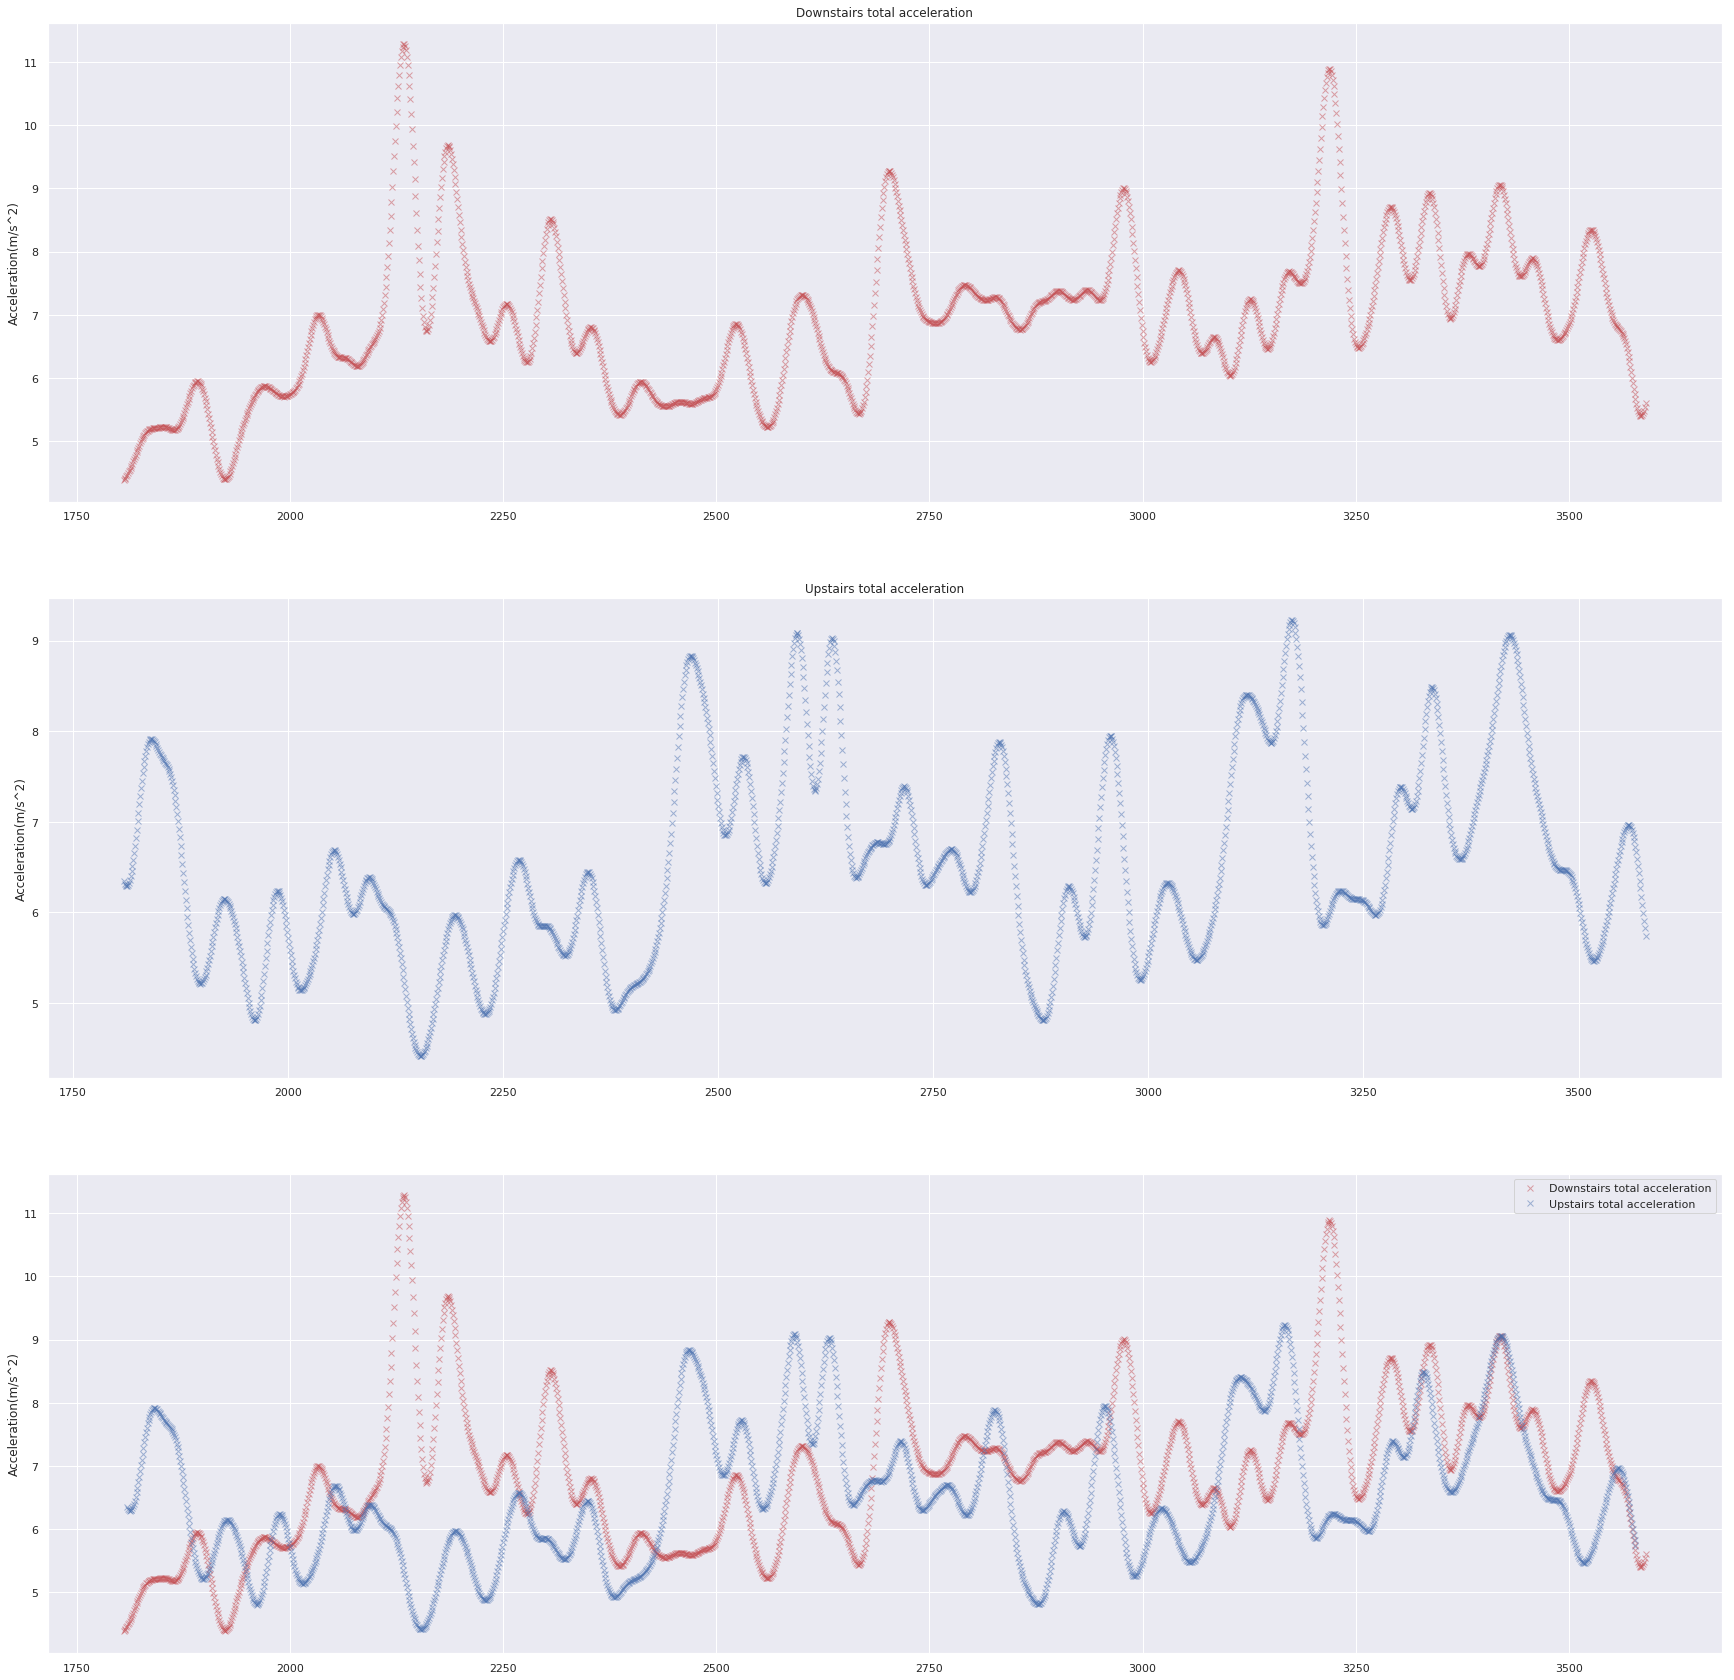

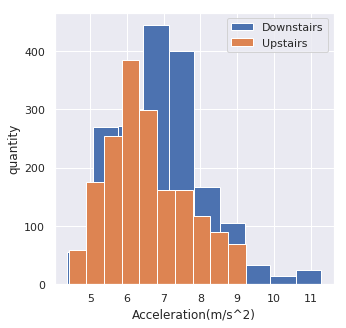

In [11]:
'''
should write in main() , now for test
'''
data_down = get_stairs_data('down')
data_up = get_stairs_data('up')
analysis_stairs(data_down , data_up)

# Fourier transform analysis 

In [12]:
def get_FFT_data():
    '''
    Get the data after the Fourier Transform and then for each catogary(one catogary 15 files) calculate the average
    total acceleration
    Return a list contain dataFrame  
    '''

    # Build a new dataFrame because we can do plus immediately  
    data_downstairs_inpocket = pd.DataFrame()
    data_downstairs_hold = pd.DataFrame()
    data_upstairs_inpocket = pd.DataFrame()
    data_upstairs_hold = pd.DataFrame()
    data_walk_inpocket = pd.DataFrame()
    data_walk_hold = pd.DataFrame()
    
    data_downstairs_inpocket = Butterworth_filter_and_FFT(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(1)))[0]
    data_downstairs_hold = Butterworth_filter_and_FFT(read_csv('downstairs_hold' , 'downstairs_hold' + str(1)))[0]
    data_upstairs_inpocket = Butterworth_filter_and_FFT(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(1)))[0]
    data_upstairs_hold = Butterworth_filter_and_FFT(read_csv('upstairs_hold' , 'upstairs_hold' + str(1)))[0]
    data_walk_inpocket = Butterworth_filter_and_FFT(read_csv('walk_inpocket' , 'walk_inpocket' + str(1)))[0]
    data_walk_hold = Butterworth_filter_and_FFT(read_csv('walk_hold' , 'walk_hold' + str(1)))[0]

    # Do the plus step 
    for i in range(2 , 16):
        data_downstairs_inpocket += Butterworth_filter_and_FFT(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i)))[0]
        data_downstairs_hold += Butterworth_filter_and_FFT(read_csv('downstairs_hold' , 'downstairs_hold' + str(i)))[0]
        data_upstairs_inpocket += Butterworth_filter_and_FFT(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i)))[0]
        data_upstairs_hold += Butterworth_filter_and_FFT(read_csv('upstairs_hold' , 'upstairs_hold' + str(i)))[0]
        data_walk_inpocket += Butterworth_filter_and_FFT(read_csv('walk_inpocket' , 'walk_inpocket' + str(i)))[0]
        data_walk_hold += Butterworth_filter_and_FFT(read_csv('walk_hold' , 'walk_hold' + str(i)))[0]

    # Build a list contain all the dataFrame 
    data_list = [data_downstairs_inpocket , data_downstairs_hold , data_upstairs_inpocket , data_upstairs_hold , 
                data_walk_inpocket , data_walk_hold]
    
    
    # Calculate the average and dropnull
    for data in data_list:
        data['aT'] = data['aT'].dropna()
        data['aT'] = data['aT'] / 15
        data['freq'] = data['freq'].dropna()
        data['freq'] = data['freq'] / 15
    
    data_list[0] = data_list[0].dropna()
    data_list[1] = data_list[1].dropna()
    data_list[2] = data_list[2].dropna()
    data_list[3] = data_list[3].dropna()
    data_list[4] = data_list[4].dropna()
    data_list[5] = data_list[5].dropna()
    return data_list

In [13]:
#plot_acceleration_FFT(get_FFT_data()[5])
#data_list = get_FFT_data()

In [14]:
#data_list[0]

In [15]:
def FFT_analysis():
    '''
    We already get the data from the help function get_FFT_data. If we want to do pairwise comparsion, we need the same size
    datasets. And by looking at the datasets manualy, 0 to 1700 might be proper
    Two analysis for data after the FFT , anova test to check whether they have the same mean. 1.0966894579894682e-25
    pvalue is less than 0.05, So we they have different mean, and then we do pairwise comparsion to check which two groups 
    have different mean
    Why?  Because this is the reason we use average frequency for features
    '''
    data_list = get_FFT_data()
    # dataFrame slice
    data_list[0] = data_list[0][:1701]
    data_list[1] = data_list[1][:1701]
    data_list[2] = data_list[2][:1701]
    data_list[3] = data_list[3][:1701]
    data_list[4] = data_list[4][:1701]
    data_list[5] = data_list[5][:1701]
    
    # Anova test
    anova_pvalue = stats.f_oneway(data_list[0]['aT'] , data_list[1]['aT'] , data_list[2]['aT'] , data_list[3]['aT'] ,
                                 data_list[4]['aT'] , data_list[5]['aT']).pvalue 
    print("Anova test:" , anova_pvalue)
    
    x_data = pd.DataFrame({'downstairs_inpocket' : data_list[0]['aT'] , 'downstairs_hold' : data_list[1]['aT'] , 'upstairs_inpocket' : data_list[2]['aT'],
                          'upstairs_hold' : data_list[3]['aT'] , 'walk_inpocket' : data_list[4]['aT'] , 'walk_hold' : data_list[5]['aT']})
    x_melt = pd.melt(x_data)
    posthoc = pairwise_tukeyhsd(x_melt['value'] , x_melt['variable'] , alpha = 0.05)
    return posthoc 

Anova test: 1.0966894579894682e-25
            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
  downstairs_hold   downstairs_inpocket 18.3651   6.4573  30.2729   True 
  downstairs_hold      upstairs_hold    -6.2227  -18.1304  5.6851  False 
  downstairs_hold    upstairs_inpocket  20.1367   8.229   32.0445   True 
  downstairs_hold        walk_hold       -7.947  -19.8548  3.9608  False 
  downstairs_hold      walk_inpocket    26.4377  14.5299  38.3455   True 
downstairs_inpocket    upstairs_hold    -24.5878 -36.4955  -12.68   True 
downstairs_inpocket  upstairs_inpocket   1.7717  -10.1361 13.6794  False 
downstairs_inpocket      walk_hold      -26.3121 -38.2199 -14.4043  True 
downstairs_inpocket    walk_inpocket     8.0726  -3.8352  19.9804  False 
   upstairs_hold     upstairs_inpocket  26.3594  14.4516  38.2672   True 
   

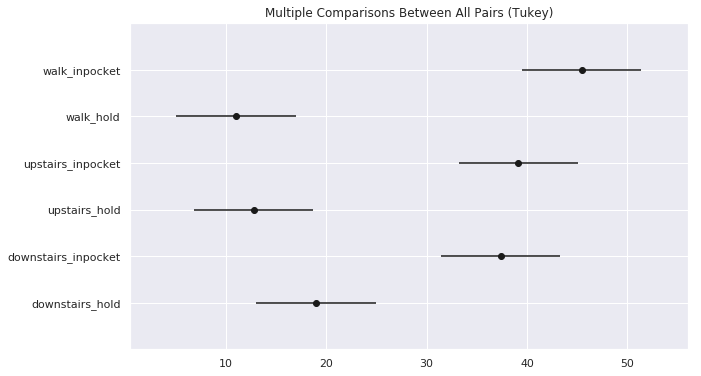

In [16]:
'''
Should write in main function 
'''
posthoc = FFT_analysis()
print(posthoc)
fig = posthoc.plot_simultaneous()

# Plot graph 
**Why Machine Learning did so good? Plot might tell us**

In [17]:
def Original_vs_Butterworth():
    '''
    Butterworth filter might give us perfect data point and because of that , Machine Learning can do better 
    Plot the graph to analysis 
    '''
    x = range(49)
    i = '7'        # change data set.

    #compare downstair_hold
    orig = get_basic_feature(read_csv('downstairs_hold' , 'downstairs_hold' + i))
    butt = get_basic_feature_butterworth(read_csv('downstairs_hold' , 'downstairs_hold' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('downstairs_hold_original' + i)
    plt.subplot(2 , 1 , 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('downstairs_hold_butterworth' + i)

    #compare downstairs_inpocket
    orig = get_basic_feature(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + i))
    butt = get_basic_feature_butterworth(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('downstairs_inpocket_original' + i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('downstairs_inpocket_butterworth' + i)

    #compare upstairs_hold
    orig = get_basic_feature(read_csv('upstairs_hold' , 'upstairs_hold' + i))
    butt = get_basic_feature_butterworth(read_csv('upstairs_hold' , 'upstairs_hold' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('upstairs_hold_original' + i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('upstairs_hold_butterworth' + i)

    #compare upstairs_inpocket
    orig = get_basic_feature(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + i))
    butt = get_basic_feature_butterworth(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('upstairs_inpocket_original' + i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('upstairs_inpocket_butterworth'+i)

    #compare walk_hold
    orig = get_basic_feature(read_csv('walk_hold' , 'walk_hold' + i))
    butt = get_basic_feature_butterworth(read_csv('walk_hold' , 'walk_hold' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('walk_hold_original' + i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('walk_hold_butterworth' + i)

    #compare walk_inpocket
    orig = get_basic_feature(read_csv('walk_inpocket' , 'walk_inpocket' + i))
    butt = get_basic_feature_butterworth(read_csv('walk_inpocket' , 'walk_inpocket' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('walk_inpocket_original'+i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('walk_inpocket_butterworth'+i)

    #compare falldown_hold
    orig = get_basic_feature(read_csv('falldown_hold' , 'falldown_hold' + i))
    butt = get_basic_feature_butterworth(read_csv('falldown_hold' , 'falldown_hold' + i))
    plt.figure(figsize = (20 , 20))
    plt.subplot(2, 1, 1)
    plt.plot(x, orig, 'b-' , alpha = 0.5)
    plt.title('falldown_hold_original' + i)
    plt.subplot(2, 1, 2)
    plt.plot(x, butt, 'b-' , alpha = 0.5)
    plt.title('falldown_hold_butterworth' + i)
    plt.show()

In [18]:
#Original_vs_Butterworth()

In [19]:
def plot_compare_feature():
    '''
    compair different catogary set: plot together
    '''
    x = range(49)
    y = get_X()
    i = 0
    n = 7*i
    plt.figure(figsize = (20, 20))
    plt.plot(x, y[0+n], 'r-' , alpha = 0.5, label = 'downstairs_hold')     # red downstairs_hold
    plt.plot(x, y[1+n], 'g-' , alpha = 0.5, label = 'downstairs_inpocket') # green downstairs_inpocket
    plt.plot(x, y[2+n], 'b-' , alpha = 0.5, label = 'upstairs_hold')       # blue upstairs_hold
    plt.plot(x, y[3+n], 'y-' , alpha = 0.5, label = 'upstairs_inpocket')   # yellow upstairs_inpocket
    plt.plot(x, y[4+n], 'k-' , alpha = 0.5, label = 'walk_hold')           # black walk_hold
    plt.plot(x, y[5+n], 'c-' , alpha = 0.5, label = 'walk_inpocket')       # cyan walk_inpocket
    plt.plot(x, y[6+n], 'm-' , alpha = 0.5, label = 'falldown_hold')       # magenta falldown_hold
    plt.legend()
    plt.show()


In [20]:
#plot_compare_feature()

In [21]:
def same_catogary():
    # downstairs_hold
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)
    s2 = 7*(n2-1)
    s3 = 7*(n3-1)
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('downstairs_hold'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('downstairs_hold'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('downstairs_hold'+str(n3))

    # downstairs_inpocket
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+1
    s2 = 7*(n2-1)+1
    s3 = 7*(n3-1)+1
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('downstairs_inpocket'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('downstairs_inpocket'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('downstairs_inpocket'+str(n3))

    # upstairs_hold
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+2
    s2 = 7*(n2-1)+2
    s3 = 7*(n3-1)+2
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('upstairs_hold'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('upstairs_hold'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('upstairs_hold'+str(n3))

    # upstairs_inpocket
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+3
    s2 = 7*(n2-1)+3
    s3 = 7*(n3-1)+3
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('upstairs_inpocket'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('upstairs_inpocket'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('upstairs_inpocket'+str(n3))

    # walk_hold
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+4
    s2 = 7*(n2-1)+4
    s3 = 7*(n3-1)+4
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('walk_hold'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('walk_hold'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('walk_hold'+str(n3))

    # walk_inpocket
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+5
    s2 = 7*(n2-1)+5
    s3 = 7*(n3-1)+5
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('walk_inpocket'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('walk_inpocket'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('walk_inpocket'+str(n3))

    # falldown_hold
    n1 = 1
    n2 = 2
    n3 = 3
    s1 = 7*(n1-1)+6
    s2 = 7*(n2-1)+6
    s3 = 7*(n3-1)+6
    plt.figure(figsize = (20 , 20))
    plt.subplot(3 , 1 , 1)
    plt.plot(x, y[s1], 'b-' , alpha = 0.5)
    plt.title('falldown_hold'+str(n1))
    plt.subplot(3 , 1 , 2)
    plt.plot(x, y[s2], 'b-' , alpha = 0.5)
    plt.title('falldown_hold'+str(n2))
    plt.subplot(3 , 1 , 3)
    plt.plot(x, y[s3], 'b-' , alpha = 0.5)
    plt.title('falldown_hold'+str(n3))

In [22]:
x = range(49)
y = get_X()
#same_catogary()